# 1. Імпорт бібліотек, встановлення сіду, налаштування pytorch на роботу на cuda

In [16]:
import torch
import random
import numpy as np
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose, RandomHorizontalFlip, RandomCrop, ToPILImage
from torch.utils.data import DataLoader, random_split, ConcatDataset, TensorDataset
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")


Using device: cuda
CUDA Device: NVIDIA GeForce RTX 2060


# 2. Завантаження FasionMNIST

In [2]:
transform = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,)),
])

data_path = '../data/lab2'
dataset = FashionMNIST(root=data_path, train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root=data_path, train=False, download=True, transform=transform)

# 3. Відображення декількох зображень з набору даних

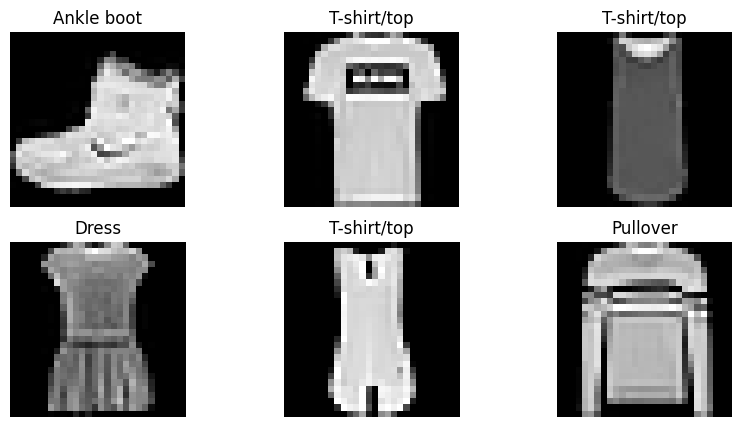

In [3]:
classes = dataset.classes

n_images = 6
rows, cols = 2, 3
figure = plt.figure(figsize=(10, 5))

for i in range(n_images):
    img, label = dataset[i]
    img = img.permute(1, 2, 0).numpy()
    ax = figure.add_subplot(rows, cols, i + 1)
    ax.imshow((img * 0.5) + 0.5, cmap='gray')
    ax.set_title(f"{classes[label]}")
    ax.axis('off')

plt.show()

# 4. Розділення даних на вибірки

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")

Train size: 48000, Validation size: 12000


In [5]:
labeled_size = int(0.3 * len(train_dataset))
unlabeled_size = len(train_dataset) - labeled_size

labeled_dataset, unlabeled_dataset = random_split(train_dataset, [labeled_size, unlabeled_size])

print(f"Labeled size: {len(labeled_dataset)}")
print(f"Unlabeled size: {len(unlabeled_dataset)}")

Labeled size: 14400
Unlabeled size: 33600


# 5. Створення даталоадерів

In [6]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
labeled_loader_teacher = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 6. Завантаження моделі GoogLeNet

In [7]:
def initialize_googlenet(num_classes, in_channels=1, aux_logits=True):
    model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1, aux_logits=aux_logits)

    model.conv1 = nn.Conv2d(
        in_channels=in_channels,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
        bias=False
    )

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

    model.transform_input = False

    model = model.to(device)
    return model

model = initialize_googlenet(num_classes=10)

/mnt/c/Users/HeyHo/Documents/GitHub/googlenet-fashionmnist/venv/lib/python3.12/site-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


# 7. Керовене навчання моделі

Epoch [1/15] - Default Model - Train Loss: 0.9065, Train Accuracy: 80.28% - Val Loss: 0.4378, Val Accuracy: 83.78%
Epoch [2/15] - Default Model - Train Loss: 0.6168, Train Accuracy: 86.62% - Val Loss: 0.3577, Val Accuracy: 87.01%
Epoch [3/15] - Default Model - Train Loss: 0.5545, Train Accuracy: 88.17% - Val Loss: 0.3153, Val Accuracy: 88.57%
Epoch [4/15] - Default Model - Train Loss: 0.4864, Train Accuracy: 89.58% - Val Loss: 0.3118, Val Accuracy: 88.59%
Epoch [5/15] - Default Model - Train Loss: 0.4357, Train Accuracy: 90.47% - Val Loss: 0.3020, Val Accuracy: 88.67%
Epoch [6/15] - Default Model - Train Loss: 0.3987, Train Accuracy: 91.35% - Val Loss: 0.2757, Val Accuracy: 90.22%
Epoch [7/15] - Default Model - Train Loss: 0.4368, Train Accuracy: 90.84% - Val Loss: 0.2932, Val Accuracy: 89.42%
Epoch [8/15] - Default Model - Train Loss: 0.3716, Train Accuracy: 91.82% - Val Loss: 0.2686, Val Accuracy: 90.27%
Epoch [9/15] - Default Model - Train Loss: 0.3296, Train Accuracy: 92.76% - Val 

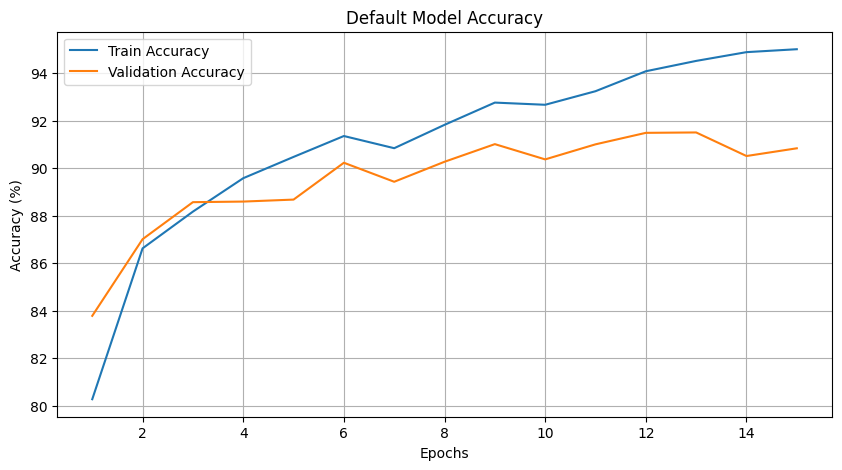

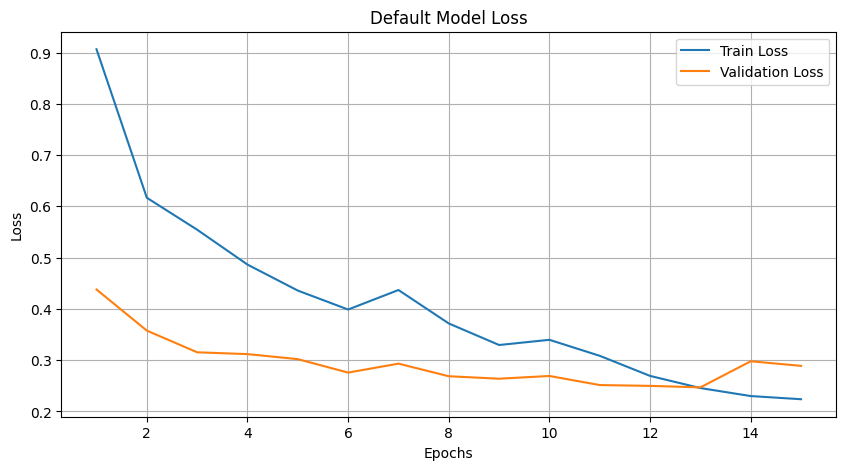

In [8]:
def calculate_loss(outputs, targets, criterion):
    if not isinstance(outputs, tuple) or len(outputs) != 3:
        return criterion(outputs, targets)
    
    main_output, aux1_output, aux2_output = outputs
    
    if main_output.size(0) != targets.size(0):
        raise ValueError(f"Batch size mismatch: main_output {main_output.size()}, targets {targets.size()}")
    
    main_loss = criterion(main_output, targets)
    aux1_loss = criterion(aux1_output, targets)
    aux2_loss = criterion(aux2_output, targets)
    return main_loss + 0.3 * (aux1_loss + aux2_loss)

def get_outputs_shape(outputs):
    if isinstance(outputs, tuple):
        return [o.shape for o in outputs]
    return outputs.shape


def train_model(model, train_loader, val_loader, num_epochs, optimizer, criterion, model_name, save_path):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            try:
                loss = calculate_loss(outputs, labels, criterion)
            except ValueError as e:
                print(f"Error in training: {e}")
                print(f"Outputs shape: {get_outputs_shape(outputs)}")
                print(f"Labels shape: {labels.shape}")
                raise
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            main_output = outputs[0] if isinstance(outputs, tuple) else outputs
            _, predicted = torch.max(main_output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                try:
                    loss = calculate_loss(outputs, labels, criterion)
                except ValueError as e:
                    print(f"Error in validation: {e}")
                    print(f"Outputs shape: {get_outputs_shape(outputs)}")
                    print(f"Labels shape: {labels.shape}")
                    raise

                val_loss += loss.item()
                main_output = outputs[0] if isinstance(outputs, tuple) else outputs
                _, predicted = torch.max(main_output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f'Epoch [{epoch+1}/{num_epochs}] - {model_name} - '
              f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}% - '
              f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%')
        
    torch.save(model.state_dict(), save_path)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{model_name} Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()
    plt.grid()
    plt.show()

train_model(model, train_loader=train_loader, val_loader=val_loader, num_epochs=15, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.CrossEntropyLoss(), model_name="Default Model", save_path="../models/lab2/googlenet_fashionmnist.pth")


# 8. Тестування моделі

In [9]:
def test_model(model, test_loader, criterion, model_name):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                main_output = outputs[0]
            else:
                main_output = outputs
            
            loss = criterion(main_output, labels)
            test_loss += loss.item()

            _, predicted = torch.max(main_output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_loss = test_loss / len(test_loader)
    
    print(f"{model_name} Test Results:")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    return test_accuracy, test_loss

test_accuracy_model, test_loss_model = test_model(model=model, test_loader=test_loader, criterion=nn.CrossEntropyLoss(), model_name="Default model")

Default model Test Results:
Test Loss: 0.2957, Test Accuracy: 90.69%


# 9. Напівкероване навчання (Noisy Student)

## 9.1. Навчання моделі-вчителя

Epoch [1/15] - Teacher Model - Train Loss: 1.2456, Train Accuracy: 73.08% - Val Loss: 0.5146, Val Accuracy: 81.52%
Epoch [2/15] - Teacher Model - Train Loss: 0.7967, Train Accuracy: 82.78% - Val Loss: 0.4369, Val Accuracy: 84.42%
Epoch [3/15] - Teacher Model - Train Loss: 0.6763, Train Accuracy: 85.42% - Val Loss: 0.4530, Val Accuracy: 84.22%
Epoch [4/15] - Teacher Model - Train Loss: 0.5853, Train Accuracy: 87.14% - Val Loss: 0.4169, Val Accuracy: 84.52%
Epoch [5/15] - Teacher Model - Train Loss: 0.5557, Train Accuracy: 88.07% - Val Loss: 0.3918, Val Accuracy: 86.28%
Epoch [6/15] - Teacher Model - Train Loss: 0.4820, Train Accuracy: 89.33% - Val Loss: 0.4539, Val Accuracy: 83.46%
Epoch [7/15] - Teacher Model - Train Loss: 0.4659, Train Accuracy: 89.90% - Val Loss: 0.3887, Val Accuracy: 86.33%
Epoch [8/15] - Teacher Model - Train Loss: 0.4259, Train Accuracy: 91.25% - Val Loss: 0.3519, Val Accuracy: 87.82%
Epoch [9/15] - Teacher Model - Train Loss: 0.3726, Train Accuracy: 91.98% - Val 

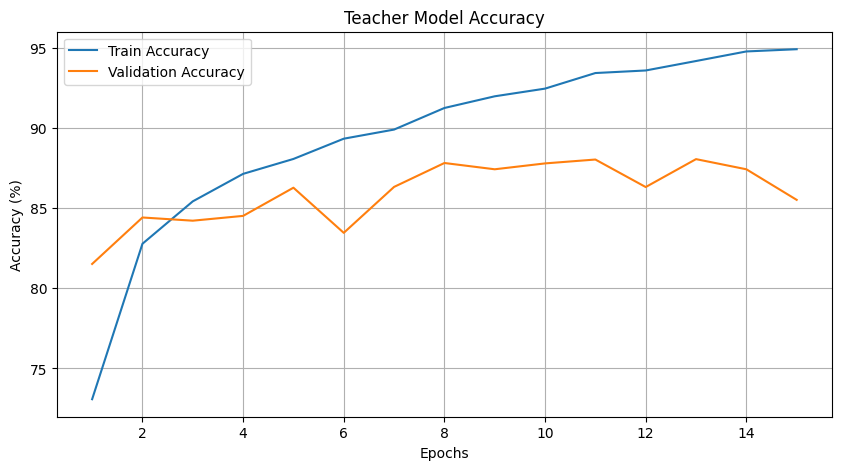

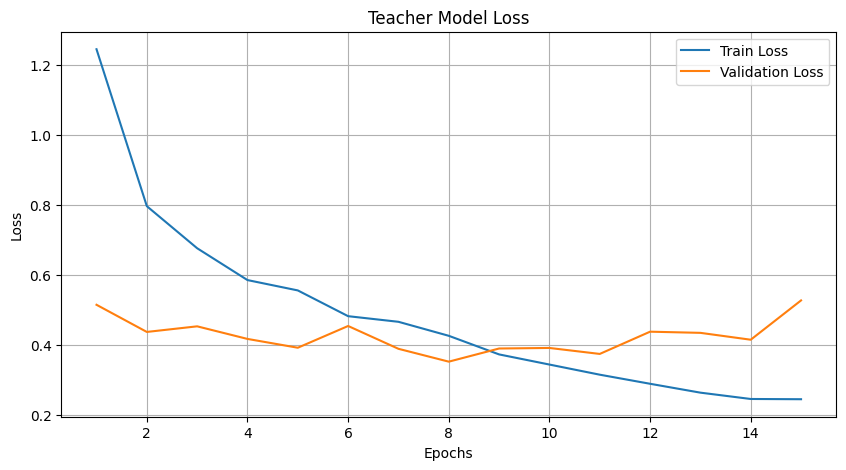

In [10]:
teacher_model = initialize_googlenet(num_classes=10)

train_model(teacher_model, train_loader=labeled_loader_teacher, val_loader=val_loader, num_epochs=15, optimizer=torch.optim.Adam(teacher_model.parameters(), lr=0.001), criterion=nn.CrossEntropyLoss(), model_name="Teacher Model", save_path="../models/lab2/teacher_model.pth")

# 9.2 Тестування моделі вчителя

In [11]:
test_accuracy_teacher, test_loss_teacher = test_model(model=teacher_model, test_loader=test_loader, criterion=nn.CrossEntropyLoss(), model_name="Teacher Model")

Teacher Model Test Results:
Test Loss: 0.5321, Test Accuracy: 85.26%


## 9.3 Генерація псевдоміток

In [12]:
teacher_model.load_state_dict(torch.load("../models/lab2/teacher_model.pth"))
teacher_model.eval()

pseudo_labels = []
unlabeled_images = []

with torch.no_grad():
    for images, _ in DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False):
        images = images.to(device)
        outputs = teacher_model(images)
        _, predicted = torch.max(outputs, 1)
        pseudo_labels.extend(predicted.cpu().numpy())
        unlabeled_images.extend(images.cpu().numpy())

print(f"Generated {len(pseudo_labels)} pseudo-labels.")

/tmp/ipykernel_41901/1207309655.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("../models/lab2/teacher_model.pth"))


Generated 33600 pseudo-labels.


## 9.4 Навчання учня

/mnt/c/Users/HeyHo/Documents/GitHub/googlenet-fashionmnist/venv/lib/python3.12/site-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch [1/15] - Student Model - Train Loss: 1.2589, Train Accuracy: 72.11% - Val Loss: 0.4925, Val Accuracy: 83.30%
Epoch [2/15] - Student Model - Train Loss: 0.8818, Train Accuracy: 80.79% - Val Loss: 0.4024, Val Accuracy: 85.42%
Epoch [3/15] - Student Model - Train Loss: 0.7610, Train Accuracy: 83.09% - Val Loss: 0.4981, Val Accuracy: 82.85%
Epoch [4/15] - Student Model - Train Loss: 0.7086, Train Accuracy: 84.46% - Val Loss: 0.3877, Val Accuracy: 86.95%
Epoch [5/15] - Student Model - Train Loss: 0.6747, Train Accuracy: 85.44% - Val Loss: 0.3518, Val Accuracy: 87.09%
Epoch [6/15] - Student Model - Train Loss: 0.6021, Train Accuracy: 86.69% - Val Loss: 0.3689, Val Accuracy: 86.67%
Epoch [7/15] - Student Model - Train Loss: 0.5500, Train Accuracy: 87.85% - Val Loss: 0.3422, Val Accuracy: 87.87%
Epoch [8/15] - Student Model - Train Loss: 0.5189, Train Accuracy: 88.59% - Val Loss: 0.3289, Val Accuracy: 88.43%
Epoch [9/15] - Student Model - Train Loss: 0.4754, Train Accuracy: 89.40% - Val 

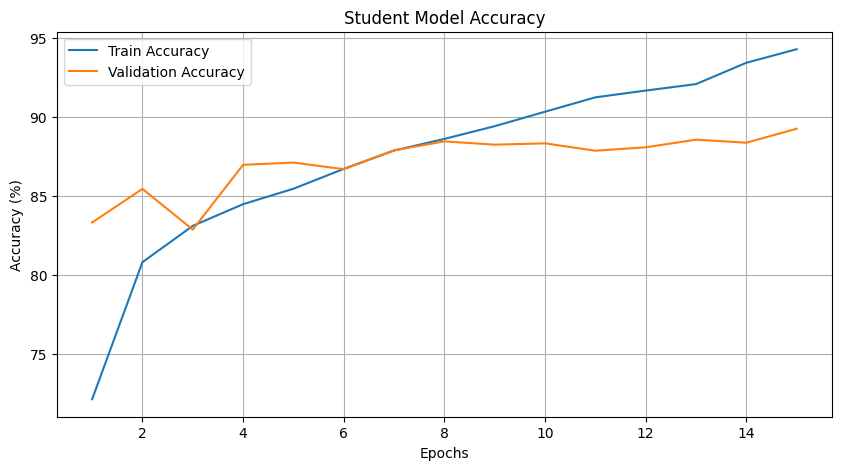

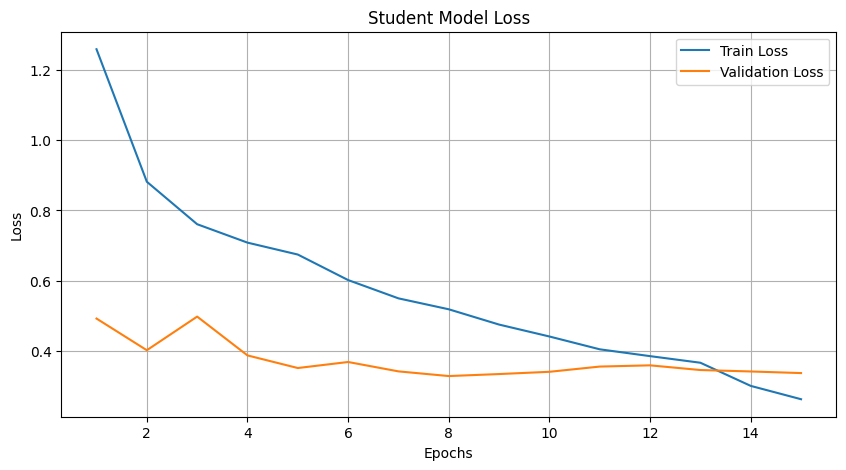

In [20]:
student_model = initialize_googlenet(num_classes=10)

labeled_images = torch.stack([img for img, _ in labeled_dataset])
labeled_labels = torch.tensor([label for _, label in labeled_dataset], dtype=torch.long)

labeled_tensor_dataset = TensorDataset(labeled_images, labeled_labels)

student_transform = Compose([
    RandomHorizontalFlip(),
    RandomCrop(28, padding=4),
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

to_pil = ToPILImage()
pseudo_images = []

if not isinstance(unlabeled_images, torch.Tensor):
    for image in unlabeled_images:
        image_tensor = torch.tensor(image)
        image_pil = to_pil(image_tensor)
        pseudo_images.append(student_transform(image_pil))

pseudo_images = torch.stack(pseudo_images)

if not isinstance(pseudo_labels, torch.Tensor):
    pseudo_labels = torch.tensor(pseudo_labels, dtype=torch.long)

pseudo_dataset = TensorDataset(pseudo_images, pseudo_labels)
combined_dataset = ConcatDataset([labeled_tensor_dataset, pseudo_dataset])
student_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

train_model(model=student_model, train_loader=student_loader, val_loader=val_loader, num_epochs=15, optimizer=torch.optim.Adam(student_model.parameters(), lr=0.001), criterion=nn.CrossEntropyLoss(), model_name="Student Model", save_path="../models/lab2/student_model.pth")

# 9.5 Тестування моделі учня

In [ ]:
test_accuracy_student, test_loss_student = test_model(model=student_model, test_loader=test_loader, criterion=nn.CrossEntropyLoss(), model_name="Student Model")

Student Model Test Results:
Test Loss: 0.4663, Test Accuracy: 87.79%
